The purpose of this notebook is to build a robust cluster finding algorithm that produces meaningful results for my computational astrophysics star cluster formation simulations. Typical out-of-the-box cluster finders rely on particle number density, or nearest neighbor criteria. Such techniques work well for observational research in which less information is known about star or galaxy cluster members. 

What am I interested in?
* Analysis on how much material (stars) is in a bound state within the identified clusters
* use 'boundedness' as a criteria for cluster identification
* fraction of bound stars in system over time

What scientific question am I trying to answer with this tool?
* Early forming massive stars form looser assosciations of stars rather than allowing for more massive clusters.
    * potential profile of cluster
    * density profile of cluster

    
Methods to create this tool:
* Have DBSCAN find clusters from all stars and report.
* remove stars that have negative energy (considering all other stars and gas). Recalculate star total energies. Remove E_tot > 0 stars, recalculate energies. Repeat until all stars have E_tot < 0. 
    * This method feels like it might have some issues as the removed stars still will contribute to potential in reality.
    * but [Li+2019](https://arxiv.org/pdf/1904.11987.pdf) found that such a recursive technique results in identification of clusters with lagrangiian radii consistently near the 60% mass bin using the conventional cluster identification method.

# Vanilla DBSCAN technique
DBSCAN ([Wiki](https://en.wikipedia.org/wiki/DBSCAN), [scipy docs](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)) or Density-Based Spatial Clustering of Applications with Noise, is a clustering algorithm originally proposed in 1996 (Ester et al. 1996) which idenitifies data points that are densely clustered (points with many nearest neighbors) and excludes those with few nearest neighbors.

DBSCAN can be used to identify star clusters. 
1. Input all stars in computational domain
2. Pass through DBSCAN, report clusters

Cons to this method: DBSCAN does not have any knowledge of dynamics. Only looks for spatially separated density peaks, therefore will have a tendency to overestimate the fraction of stars that are truly members of a particular cluster (includes stars in a cluster even if the stars have v > escape velocity).

In [28]:
import numpy as np
from amuse.lab import generic_unit_converter, nbody_system
from amuse.lab import units as u
from amuse.lab import Particles
import amuse.lab

import matplotlib
matplotlib.use('Agg')
import matplotlib
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 24}

matplotlib.rc('font', **font)
matplotlib.rc({'savefig.dpi':300})
import matplotlib.pyplot as plt

from functools import partial
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

import sys
import h5py

In [29]:
def find_clusters_with_dbscan(stars, outer_density_limit=1.0 | u.MSun*u.parsec**-3,
                              avg_stellar_mass=0.586,
                              eps=0.4, min_samples=12, leaf_size=30,
                              return_labels=False, debug=False):

    """
    Find all the stars in clusters using
    the DBSCAN implementation from scikit-learn.

    Keyword Arguments:
    stars               -- AMUSE particle set
    outer_density_limit -- If set, use this density_limit
                           in solar masses per parsec^-3 to
                           compute eps to figure
                           out where the cluster edges are
                           instead of the input eps. 
                           A good default choice
                           is 1.0 MSun * pc^-3.
                           Note this setting overrides eps.
    avg_stellar_mass    -- Average stellar mass of the IMF
                           used to make the stars your
                           clustering. Default is 
                           from a Kroupa IMF that goes 
                           from 0.08 to 150 Msun.
    eps                 -- Minimum  neighbor distance to be
                           considered in the cluster in pc.
                           This value is calculated for you
                           if you use outer_density_limit.
    min_samples         -- Minimum number of neighbors to
                           be considered a core particle.
                           Default is 12, the default for
                           DBSCAN.
    leaf_size           -- Number of particles in a leaf
                           on the KD tree the code uses
                           to find neighbors. Default is
                           30, the default for DBSCAN.
    return_labels       -- Also return the raw DBSCAN label output?
    debug               -- Turn on debugging output

    Returns:
    groups        -- A list of particle sets for the particles in each cluster.
    n_groups      -- The number of clusters found.
    labels        -- The actual label indicies returned by DBSCAN,
                     only returned if return_labels=True.
    unique_labels -- The unique labels returned by DBSCAN,
                     only returned if return_labels=True.
    """

    pre = "[find_clusters_with_dbscan]:"

    if (outer_density_limit is not None):

        # The number of samples should
        # be greater than that of
        # the average density of the
        # SN in a pc^3 (~ 0.01, BT), but not as high
        # as that of an open cluster 
        # (~10 Msun / pc^3, Binney and Tremaine)

        # Note the mean number density of the solar
        # neighborhood is 0.17 stars per parsec^3,
        # while the mean in an open cluster is 17 stars
        # per parsec^3, so a good choice is the mean
        # of these in log space, or about 1 star per parsec^-3.

        # So here we are saying they should be at least closer
        # that the average distance between stars in the SN.
        number_density_limit = (outer_density_limit.value_in(u.MSun*u.parsec**-3) 
                             / avg_stellar_mass)

        if (number_density_limit < 0.17):
            print(pre, "WARNING: Your number density limit \
                        at", number_density_limit, "pc^-3 \
                        is smaller than that of the solar \
                        neighborhood, which is ~ 0.17 pc^-3!")

        eps = number_density_limit**(-1./3.)

    if (debug):
        print(pre, "outer_density_limit  =", outer_density_limit)
        print(pre, "avg_stellar_mass     =", avg_stellar_mass)
        print(pre, "number_density_limit =", number_density_limit)
        print(pre, "eps =", eps)

    particle_positions = stars.position.value_in(u.parsec)

    # Note: I don't think its necessary to scale
    #       the inputs for DBSCAN when you are
    #       using a simple Eulerian metric on 3-d
    #       position space, as its just rescaling eps.

    # Get a DBSCAN instance running.
    db = DBSCAN(eps=eps, min_samples=min_samples, leaf_size=leaf_size)
    # Do the clustering.
    clstrs = db.fit_predict(particle_positions)
    # Get the unique cluster lables (i.e. the number of clusters).
    labels = db.labels_
    unique_labels = set(labels) # This returns only the unique ones.
    # Anything with an index of -1 is noise.
    tmp = []
    for val in unique_labels:
        if val >= 0: 
            tmp.append(1)
    n_groups = len(tmp)
    #n_groups = len(filter((lambda x: x>=0),unique_labels))
    groups = []

    for label in unique_labels:
        if (label >= 0): # Don't include noise particles here.
            groups.append(stars[np.where(labels == label)[0]])

    if (debug):
        print(pre, "groups=", groups)
        print(pre, "n_groups=", n_groups)
        print(pre, "labels=", labels)
        print(pre, "unique_labels=", unique_labels)

    if (return_labels):
        return groups, n_groups, labels, unique_labels
    else:
        return groups, n_groups

In [ ]:
f = h5py.File('./example_data/DBSCAN_input/L3-50M-2tff_stars.amuse', 'r')
list(f.keys())
dset = f['data']
print(dset)
#find_clusters_with_dbscan(file_,debug=True)

In [31]:
conv = generic_unit_converter.ConvertBetweenGenericAndSiUnits(
        1.0 | u.cm, 1.0 | u.g, 1.0 | u.s)
stars = amuse.io.read_set_from_file("./example_data/DBSCAN_input/L3-50M-2tff_stars.amuse", format='amuse')
groups, n_groups = find_clusters_with_dbscan(stars,debug=True)

[find_clusters_with_dbscan]: outer_density_limit  = 1.0 MSun * parsec**-3
[find_clusters_with_dbscan]: avg_stellar_mass     = 0.586
[find_clusters_with_dbscan]: number_density_limit = 1.70648464164
[find_clusters_with_dbscan]: eps = 0.83682093912
[find_clusters_with_dbscan]: groups= [<amuse.datamodel.particles.ParticlesSubset object at 0x120382e90>, <amuse.datamodel.particles.ParticlesSubset object at 0x120291a10>, <amuse.datamodel.particles.ParticlesSubset object at 0x118fa0b50>, <amuse.datamodel.particles.ParticlesSubset object at 0x120b0a590>, <amuse.datamodel.particles.ParticlesSubset object at 0x120b0a6d0>, <amuse.datamodel.particles.ParticlesSubset object at 0x120b0da50>]
[find_clusters_with_dbscan]: n_groups= 6
[find_clusters_with_dbscan]: labels= [-1 -1  0 ...,  4  4  4]
[find_clusters_with_dbscan]: unique_labels= {0, 1, 2, 3, 4, 5, -1}


In [33]:
print(type(groups))
print(len(groups[0]))
print(groups[0].center_of_mass().value_in(u.m))
for group in groups:
    print(group.mass.sum().value_in(u.MSun))
    #print(group.center_of_mass().value_in(u.m))


<class 'list'>
275
[  6.98503808e+15  -9.76110951e+16   6.49901847e+16]
162.165051596
267.315273937
287.074672166
56.8391259629
548.551931604
49.0412785632


# Blah

Now we are able to find clusters in any given AMUSE particle set. Now, need to write a function that, when given a star list constituting one or more clusters, will calculate the cluster(s)' center of mass, and the boundedness of each star to those centers of masses. Then, discard all stars that are not bound to any cluster, and return a AMUSE particle set that is once again NOT separated into clusters.

Summary of upcomming function:
1. input particle lists of clusters
2. calculate clusters' centers of mass, center of mass velocity
3. calculate boundedness of all stars to the cluster they belong to (and maybe also to other cluster com's?)
4. return a single particle set only containing remaining stars (and no separation by cluster).


In [ ]:
def calculate_cluster_com_props(sg):
    group_com = []
    group_comv = []
    tmp_vel_arr = np.zeros(3)
    
    group_com.append(sg.center_of_mass().value_in(u.m))
    tmp_vel_arr[0]  = ((sg.mass*sg.vx).sum() / sg.mass.sum()).value_in(u.m / u.s)
    tmp_vel_arr[1]  = ((sg.mass*sg.vy).sum() / sg.mass.sum()).value_in(u.m / u.s)
    tmp_vel_arr[2]  = ((sg.mass*sg.vz).sum() / sg.mass.sum()).value_in(u.m / u.s)
    group_comv.append(tmp_vel_arr)
        
    return group_com, group_comv
        

In [ ]:
for sg in groups:
    c,v = calculate_cluster_com_props(sg)
print(type(c[0]))
print(groups[0].position)

TO FIND STAR BOUNDNEDNESS TO CLUSTER COM, LET'S DO ARRAY BROADCASTING! iT SHOUDL WORK, SHOUDL END WITH AN ARRAY OF BOUNDEDNESS VALUES THAT CAN THEN BBE USED TO SELECT FOR NEGATIVE VALUES THEN RETURN THE CORRESPONDING STARS

In [ ]:
def calculate_star_boundedness_to_cluster_com(groups):
    G = 6.6743e-11 #m^3 kg^-2 s^-1
    total_stars = Particles()
    
    for sg in groups: # Cycle through each particle set within the list groups
        # Extract star positions, masses, velocities
        stars_xyz = sg.position.value_in(u.m)
        stars_mass = sg.mass.value_in(u.kg).reshape(len(stars_xyz),1)
        stars_vel = sg.velocity.value_in(u.m/u.s)
        stars_vel_mag = np.sqrt((sg.velocity.value_in(u.m/u.s)**2).sum(axis=1)).reshape(len(stars_xyz),1)
        # Get mass of particle set
        group_mass = sg.mass.sum().value_in(u.kg)
        # Get center of mass and com velocity of the particle set
        # and convert into len(stars)x1 array so we can do array broadcasting.
        group_com, group_comv = calculate_cluster_com_props(sg)
        com_column = np.tile(group_com,(len(stars_xyz),1))
        comv_column = np.tile(group_comv,(len(stars_xyz),1))
        
        # Broadcast arrays to get each particle's velocity relative to com velocity
        stars_vel_rel = stars_vel - comv_column
        stars_vel_rel_mag = np.sqrt((stars_vel_rel**2).sum(axis=1)).reshape(len(stars_xyz),1)
        # Same method for particle distance to com
        dist_to_com = np.sqrt(((stars_xyz-com_column)**2).sum(axis=1)).reshape(len(stars_xyz),1)

        star_KE = (0.5 * stars_mass * stars_vel_rel_mag**2).reshape(len(stars_xyz),1)
        star_PE = (-1.0 * G * group_mass * stars_mass / dist_to_com)
        star_TE = star_KE + star_PE
        
        sg_copy = sg.copy(keep_structure=True)
        unbound_star_ind = np.where(star_TE > 0)
        for ind in unbound_star_ind:
            sg_copy.remove_particle(sg_copy[ind])
        print(len(sg),len(sg_copy))
        total_stars += sg_copy

    return total_stars
calculate_star_boundedness_to_cluster_com(groups)

In [ ]:
# s = np.array([[1,1,1], [2,2,2], [3,3,3]])
# x = np.array([1,1,1])
# dist = np.zeros((len(s),1))
# print(dist)
# for i,point in enumerate(s):
#     dist[i] = np.linalg.norm(x-s[i])
# print(dist)
x1 = np.tile(x,(len(s),1))

dist = np.sqrt(((s-x1)**2).sum(axis=1)).reshape(len(s),1)
print(dist)
print(groups[0].velocity.value_in(u.m/u.s))

# Iterative bound-fraction method

[Li, H. (2019)](https://arxiv.org/pdf/1904.11987.pdf) reported using an iterative method of removing all stars from the computational domain with a positive energy:
1. Calculate total energy of all stars (Li+19 only looks at potentials from other stars since the system has evolved to be gas-less, I will need to consider the grav potential of the gas).
2. Remove all stars with positive total energy.
3. Repeat 1,2 until all stars have negative energy.

It's possible I could modify this method by also removing all gas cells that have positive energy as well.

Li+19 found that the iterative method was an appropriate way to determine the fraction of bound stars and was superior than tracking the lagrangiian radius over time for the entitre computational domain.

What I want to do:

I want to perform the iterative bound fraction method on my 2tff data outputs to compare bound fractions of stars at that point in time. If the method is quick, I'd like to do this for all of my data for each run to track the bound fraction over time. 

Then, I'd like to calculate the lagrangian radii for the entire computational domain and track over time and compare between each run and their bound fraction over time. (Figure 7 from Li+19) 

In [ ]:
import yt
import numpy as np
# load turbsph_hdf5 plt file for 2tff
ds = yt.load('../Torch-Analysis/Paper1-runs-snapshots/L3-50M/2tff_hdf5_plt_2133',
             particle_filename='../Torch-Analysis/Paper1-runs-snapshots/L3-50M/2tff_hdf5_part_2133')
ad = ds.all_data()
print(ds.derived_field_list)

In [ ]:
# calculate energy of each star (KE_s + PE_s + PE_g)
star_ind = np.where(ad['particle_type']==1.) # separate star particles from sinks
star_kine = 0.5*ad['particle_mass'][star_ind]*(ad['particle_velocity_x'][star_ind]**2 \
                                               + ad['particle_velocity_y'][star_ind]**2 \
                                               + ad['particle_velocity_z'][star_ind]**2)
star_ener = star_kine.v+ad['particle_gpot'][star_ind].v*ad['particle_mass'][star_ind].v

print(len(np.where(star_ener<0.0)[0]))
print(len(np.where(star_ener>0.0)[0]))
neg_ener_ind = np.where(star_ener<0.0)[0] # get indices for negative energy stars
# note which stars have positive energy
star_ener2 = star_kine.v+ad['particle_gpot'][star_ind].v*ad['particle_mass'][star_ind].v
print(star_ener2[neg_ener_ind])
# recalculate star energies EXCLUDING positive energy stars

# repeat

## Encountering a little problem

What I am able to do now: 

I can find the stars that have negative total energy due to gas and stars via yt fields. But I cannot iterate this calculation because the only information I have is a single data point from FLASH consitiuting the potential a star feels due to all the gas and all the particles. Therefore, once I make this initial calculation, I am not able to update this data with the new set of particles (now without the Etot>0 stars).

I need a different way of going about this where I have more direct control over the gravitational potential data. 

The best way I can think of right now is to convert the yt gas output into amuse stars and add to AMUSE particle set and use AMUSE functionality to quickly calculate the grav potential exerted by gas on each star.

Calculate lagrangian radii with AMUSE functionality

In [ ]:
import numpy as np
from amuse.lab import generic_unit_converter, nbody_system
from amuse.lab import units as u
from amuse.lab import Particles
import amuse.lab

In [ ]:
num_gas = len(ad['dens'])
gas = Particles(num_gas)

gas.tag = np.zeros(num_gas)
gas.mass = ad['cell_mass'].v | u.g
gas.x = ad['x'].v | u.cm
gas.y = ad['y'].v | u.cm
gas.z = ad['z'].v | u.cm
gas.vx = ad['velocity_x'].v | u.cm/u.s
gas.vy = ad['velocity_y'].v | u.cm/u.s
gas.vz = ad['velocity_z'].v | u.cm/u.s

num_stars = len(ad['particle_mass'].v)
stars = Particles(num_stars)

stars.tag = np.ones(num_stars)
stars.mass = ad['particle_mass'].v | u.g
stars.x = ad['particle_position_x'].v | u.cm
stars.y = ad['particle_position_y'].v | u.cm
stars.z = ad['particle_position_z'].v | u.cm
stars.vx = ad['particle_velocity_x'].v | u.cm/u.s
stars.vy = ad['particle_velocity_y'].v | u.cm/u.s
stars.vz = ad['particle_velocity_z'].v | u.cm/u.s


superset = Particles()
superset.add_particles(gas)
print(superset.tag)
superset.add_particles(stars)
print(superset.tag)

Need to reduce the computation time. I dont care about the potenital at the points of gas, only the stars. For a single star, the computationally heavy bit is calculating the potential at its location due to all the gas (200k particles). I dont want to have to do this calculation each time I ditch some stars, in fact, I only have to do the gas calculation once, save the potential as a AMUSE attribute in the original stars particle set and then continue with just the stars from there!

The calculation of the poential due to the other stars will have to be repeated each time I update the number of stars present, but that will be a comparatively simple operation.

I just need to use the indexing functionality of numpy arrays to calculate the potential of only the particles in the superset tagged as stars. Gotta start thinking in broadcasting/vectorization terms

In [ ]:
star_pot_from_gas_and_stars = superset[np.where(superset.tag==1.)].potential().as_quantity_in(u.cm**2 / u.s**2)
# add potential energy to stars atrributes
stars.potE = star_pot_from_gas_and_stars

star_total_E = (stars.specific_kinetic_energy() + stars.potE)*stars.mass

In [ ]:
unbound_ind = np.where(star_total_E.value_in(u.kg*u.m**2/u.s**2) > 0)[0]
stars1 = stars.copy()
stars1.remove_particles(stars[unbound_ind])

In [ ]:
print(len(stars.x))
print(len(stars1.x))

In [ ]:
superset1 = Particles()
superset1.add_particles(gas)
superset1.add_particles(stars1)

star_pot_from_gas_and_stars = superset1[np.where(superset1.tag==1.)].potential().as_quantity_in(u.cm**2 / u.s**2)
# add potential energy to stars atrributes
stars1.potE = star_pot_from_gas_and_stars

star_total_E = (stars1.specific_kinetic_energy() + stars1.potE)*stars1.mass
unbound_ind = np.where(star_total_E.value_in(u.kg*u.m**2/u.s**2) > 0)[0]

stars2 = stars1.copy()
stars2.remove_particles(stars1[unbound_ind])

superset2 = Particles()
superset2.add_particles(gas)
superset2.add_particles(stars2)
star_pot_from_gas_and_stars = superset2[np.where(superset2.tag==1.)].potential().as_quantity_in(u.cm**2 / u.s**2)
stars2.potE = star_pot_from_gas_and_stars

star_total_E = (stars2.specific_kinetic_energy() + stars2.potE)*stars2.mass
unbound_ind = np.where(star_total_E.value_in(u.kg*u.m**2/u.s**2) > 0)[0]

stars3 = stars2.copy()
stars3.remove_particles(stars2[unbound_ind])

superset3 = Particles()
superset3.add_particles(gas)
superset3.add_particles(stars3)
star_pot_from_gas_and_stars = superset3[np.where(superset3.tag==1.)].potential().as_quantity_in(u.cm**2 / u.s**2)
stars3.potE = star_pot_from_gas_and_stars

star_total_E = (stars3.specific_kinetic_energy() + stars3.potE)*stars3.mass
unbound_ind = np.where(star_total_E.value_in(u.kg*u.m**2/u.s**2) > 0)[0]

stars4 = stars3.copy()
stars4.remove_particles(stars3[unbound_ind])
print(len(stars.x))
print(len(stars1.x))
print(len(stars2.x))
print(len(stars3.x))
print(len(stars4.x))




### Iterative technique works!!
Great!! It seems like we can remove unbound stars and recalculate the total energy of all stars while taking into account the background gas at the same time.

Now let's put this into a single function.

    

In [ ]:
def make_amuse_set_gas_and_stars(input_hdf5_plt, input_hdf5_part):
    """
    Creates an AMUSE particle set from a FLASH output 
    containing gas cells and star particles.
    Both gas cells and star particles are converted
    into AMUSE particles and are catagorized by tag:
    gas (0), star (1). The resulting particle set
    has attributes of tag, mass, position, and 
    velocity.
    """
    ds = yt.load('../Torch-Analysis/Paper1-runs-snapshots/L3-50M/2tff_hdf5_plt_2133',
                 particle_filename='../Torch-Analysis/Paper1-runs-snapshots/L3-50M/2tff_hdf5_part_2133')
    ad = ds.all_data()
    num_gas = len(ad['dens'])
    gas = Particles(num_gas)

    gas.tag = np.zeros(num_gas)
    gas.mass = ad['cell_mass'].v | u.g
    gas.x = ad['x'].v | u.cm
    gas.y = ad['y'].v | u.cm
    gas.z = ad['z'].v | u.cm
    gas.vx = ad['velocity_x'].v | u.cm/u.s
    gas.vy = ad['velocity_y'].v | u.cm/u.s
    gas.vz = ad['velocity_z'].v | u.cm/u.s

    num_stars = len(ad['particle_mass'].v)
    stars = Particles(num_stars)

    stars.tag = np.ones(num_stars)
    stars.mass = ad['particle_mass'].v | u.g
    stars.x = ad['particle_position_x'].v | u.cm
    stars.y = ad['particle_position_y'].v | u.cm
    stars.z = ad['particle_position_z'].v | u.cm
    stars.vx = ad['particle_velocity_x'].v | u.cm/u.s
    stars.vy = ad['particle_velocity_y'].v | u.cm/u.s
    stars.vz = ad['particle_velocity_z'].v | u.cm/u.s

    return stars, gas

def calculate_star_totE(input_stars, input_gas):
    superset = Particles()
    superset.add_particles(input_gas)
    superset.add_particles(input_stars)
    
    star_pot_from_gas_and_stars = superset[np.where(superset.tag==1.)].potential().as_quantity_in(u.cm**2 / u.s**2)
    input_stars.potE = star_pot_from_gas_and_stars
    
    return input_stars
def remove_stars(input_stars):
    unbound = True
    star_total_E = (input_stars.specific_kinetic_energy() + input_stars.potE)*input_stars.mass
    unbound_ind = np.where(star_total_E.value_in(u.kg*u.m**2/u.s**2) > 0)[0]
    tmp_stars = input_stars.copy()
    try: 
        tmp_stars.remove_particles(input_stars[unbound_ind])
    except:
        unbound=False
    return tmp_stars, unbound

def remove_unbound_stars(input_stars, input_gas):
    superset = Particles()
    superset.add_particles(input_gas)
    superset.add_particles(input_stars)
    
    star_pot_from_gas_and_stars = superset[np.where(superset.tag==1.)].potential().as_quantity_in(u.cm**2 / u.s**2)
    # add potential energy to stars atrributes
    input_stars.potE = star_pot_from_gas_and_stars
    
    star_total_E = (input_stars.specific_kinetic_energy() + input_stars.potE)*input_stars.mass
    input_stars.totE = star_total_E
    unbound = True
    unbound_ind = np.where(star_total_E.value_in(u.kg*u.m**2/u.s**2) > 0)[0]
    try:
        if len(unbound_ind[0]) == 0:
            unbound = False
    except TypeError:
        unbound = False
    tmp_stars = input_stars.copy()
    tmp_stars.remove_particles(input_stars[unbound_ind])
    
    return tmp_stars, unbound
def iterate_star_energy(input_hdf5_plt, input_hdf5_part):
    stars, gas = make_amuse_set_gas_and_stars(input_hdf5_plt, input_hdf5_part)
    print(len(stars.mass))
    unbound = True
    while unbound:
        stars, unbound = remove_unbound_stars(stars, gas)
        print(len(stars.mass))
    print(len(stars.mass))
    return stars

In [ ]:
plt_file_path = "../Torch-Analysis/Paper1-runs-snapshots/L3-50M/2tff_hdf5_plt_2133"
part_file_path = "../Torch-Analysis/Paper1-runs-snapshots/L3-50M/2tff_hdf5_part_2133"
stars = iterate_star_energy(plt_file_path, part_file_path)



In [ ]:
print(np.where(stars.totE.value_in(u.kg*u.m**2/u.s**2)>0))


In [ ]:
input_hdf5_plt = "../Torch-Analysis/Paper1-runs-snapshots/L3-50M/2tff_hdf5_plt_2133"
input_hdf5_part = "../Torch-Analysis/Paper1-runs-snapshots/L3-50M/2tff_hdf5_part_2133"
stars, gas = make_amuse_set_gas_and_stars(input_hdf5_plt, input_hdf5_part)
unbound = True
while unbound:
    stars_ = calculate_star_totE(stars,gas)
    stars_, unbound = remove_stars(stars)
    print(len(stars_))
print(len(stars_))



### Having some trouble
This whole "combining things into one function" business is really tripping me up. 

**The problem:** For the L50M run, the remove bound-stars iteration should cycle several times (I checked this by brute force), but instead it removes stars from the domain once and then determines it is completed (no other stars have >0 Etot) and it stops. 

**Why is this happening:** It's clear that there's something wrong with how the AMUSE particle sets are being updated and reinitialized. 

**How to fix:** At the moment I've been concatenating the gas and stars into a superset AMUSE particle set, then calculating energy for the stars, saving the result to the input star particles not the superset, then copying the input star particle set, removing the star particles with an Etot of > 0, and passing out this copy of the stars. This updated copy is then passed back into the beginning of this process.

Now let's try this without all the copying, passing copies back into the iteration, etc. Let's just make a superset once an manipulate everything within the superset.

## IT WORKS!!!

In [28]:
import yt
yt.mylog.level=50
import numpy as np
from amuse.lab import generic_unit_converter, nbody_system
from amuse.lab import units as u
from amuse.lab import Particles
import amuse.lab
from time import time
def make_amuse_set_gas_and_stars(input_hdf5_plt, input_hdf5_part, calc_gas_ener=False):
    """
    Creates an AMUSE particle set from a FLASH output 
    containing gas cells and star particles.
    Both gas cells and star particles are converted
    into AMUSE particles and are catagorized by tag:
    gas (0), star (1). The resulting particle set
    has attributes of tag, mass, position, and 
    velocity.
    
    Arguments:
    input_hdf5_plt  - hdf5 plot file path
    input_hdf5_part - hdf5 particle file path
    calc_gas_ener   - flag to set particle magnetic and internal energy, 
                      used to calculate gas total energy to remove unbound gas.
                      Default is False.
    
    Returns:
    stars - star particle set
    gas   - gas particle set
    """
    # Load hdf5 files in yt so we can extract cell and particle information
    ds = yt.load(input_hdf5_plt,
                 particle_filename=input_hdf5_part)
    ad = ds.all_data()
    
    # Set gas cell properties as AMUSE particle data
    num_gas = len(ad['dens'])
    gas = Particles(num_gas)
    
    gas.tag = np.zeros(num_gas)
    gas.mass = ad['cell_mass'].v | u.g
    gas.x = ad['x'].v | u.cm
    gas.y = ad['y'].v | u.cm
    gas.z = ad['z'].v | u.cm
    gas.vx = ad['velocity_x'].v | u.cm/u.s
    gas.vy = ad['velocity_y'].v | u.cm/u.s
    gas.vz = ad['velocity_z'].v | u.cm/u.s
    if (calc_gas_ener):
        # Set gas thermal and magnetic energy
        gas.ME = ad['magp'].v*ad['cell_volume'].v / 4.0 / np.pi | u.erg
        gas.EI = ad['cell_mass'].v * ad['eint'].v | u.erg
        
    # Set star particle properties as AMUSE particle data
    # (must be same labels for when we concatenate with gas)
    num_stars = len(ad['particle_mass'].v)
    stars = Particles(num_stars)

    stars.tag = np.ones(num_stars)
    stars.mass = ad['particle_mass'].v | u.g
    stars.x = ad['particle_position_x'].v | u.cm
    stars.y = ad['particle_position_y'].v | u.cm
    stars.z = ad['particle_position_z'].v | u.cm
    stars.vx = ad['particle_velocity_x'].v | u.cm/u.s
    stars.vy = ad['particle_velocity_y'].v | u.cm/u.s
    stars.vz = ad['particle_velocity_z'].v | u.cm/u.s
    if (calc_gas_ener):
        # Set dummy magnetic and internal energy
        stars.ME = np.zeros(num_stars) | u.erg
        stars.EI = np.zeros(num_stars) | u.erg

    return stars, gas

def setup_superset(input_hdf5_plt, input_hdf5_part, calc_gas_ener=False):
    '''
    Generates an AMUSE superset of gas and star particles
    tags = [0] and [1] respectively.
    Gas and star particles have positions, velocities, and masses.
    
    We then calculate the total energy of each star particle
    based on its KE, and PE due to all other stars and gas
    using update_total_E(superset).
    
    Arguments:
    input_hdf5_plt  - hdf5 plot file path
    input_hdf5_part - hdf5 particle file path
    calc_gas_ener   - flag to set particle magnetic and internal energy, 
                      used to calculate gas total energy to remove unbound gas.
                      Default is False.
    
    Other Function Calls:
    update_total_E(superset,calc_gas_ener)
    
    Returns:
    superset - star and gas particles
    '''
    # First extract star and gas positions, velocities, and masses
    # from hdf5 output using yt.
    stars, gas = make_amuse_set_gas_and_stars(input_hdf5_plt, input_hdf5_part, calc_gas_ener)
    
    # Build superset.
    superset = Particles()
    superset.add_particles(gas)
    superset.add_particles(stars)
    # Calculate and set total energy particle attribute
    superset = update_total_E(superset, calc_gas_ener)
    return superset

def update_total_E(superset,calc_gas_ener=False):
    '''
    Calculates the Total Energy of all the particles 
    tagged as [1] (star) in an AMUSE superset. We do some 
    casual array indexing to ensure the potential calculation
    for the star particles includes the masses of all the gas,
    but does not calculate the potential for each gas particle.
    
    We then update the totE quantity of the superset, setting
    the totE for the stars as our calculated values and the 
    totE for the gas as -1 (since we dont need this value and
    this ensures the gas is not removed from the superset in
    upcoming steps).
    
    Arguments:
    superset - AMSUE superset of gas and star particles
    calc_gas_ener   - flag to set particle magnetic and internal energy, 
                      used to calculate gas total energy to remove unbound gas.
                      Default is False.
    
    Returns:
    superset - superset with updated totE values
    '''
    # Calculate total energy of star particles only
    # starKE + PE_stars + PE_gas
    star_ind = np.where(superset.tag==1.)
    star_pot_from_gas_and_stars = superset[star_ind].potential().as_quantity_in(u.cm**2 / u.s**2)
    star_spec_kine = superset[star_ind].specific_kinetic_energy().as_quantity_in(u.cm**2 / u.s**2)
    star_mass = superset[star_ind].mass.as_quantity_in(u.g)
    star_totE = star_mass*(star_spec_kine+star_pot_from_gas_and_stars)
    
    gas_ind = np.where(superset.tag==0.)
    if (calc_gas_ener):
        # Calculate gas total energy
        print("Calculating gas potential...") # Printing to screen b/c this step can take a while
        gas_pot_from_gas_and_stars = superset[gas_ind].potential().as_quantity_in(u.cm**2 / u.s**2)
        gas_spec_kine = superset[gas_ind].specific_kinetic_energy().as_quantity_in(u.cm**2 / u.s**2)
        gas_mass = superset[gas_ind].mass.as_quantity_in(u.g)
        gas_ME = superset[gas_ind].ME.as_quantity_in(u.J)
        gas_EI = superset[gas_ind].EI.as_quantity_in(u.J)
        gas_totE = gas_mass*(gas_spec_kine+gas_pot_from_gas_and_stars)+gas_ME+gas_EI
    else:
        # Set dummy totE attribute to gas particles
        gas_totE = (-1 | u.J)*np.ones(len(superset[gas_ind]))
    # Set superset totE attribute as concatenated gas and star totE arrays.
    superset.totE = np.concatenate((gas_totE.as_quantity_in(u.J),star_totE.as_quantity_in(u.J)))
    return superset
def iterate_remove_stars(superset, iterate_gas_ener=False, 
                         report_removal_stats=False, save_all_psets=False, 
                         savepath_prefix=''):
    '''
    Iteration following the steps:
    1. Remove star particles from superset with total E > 0.
    2. Check if we did in fact remove stars, if No then set break bool.
    3. Update star total energies using updated superset particles.
    
    Arguments:
    superset             - AMUSE particle superset of gas and star particles
    iterate_gas_ener     - Flag to iteratively remove unbound gas.
                           Only set to True in conjunction with calc_gas_ener.
                           Setting to True is not recommended for refined 
                           simulations as the operation is very expensive.
                           Default is False.
    report_removal_stats - Report number of stars removed, 
                           total mass of removed stars.
    
    Other Function Calls:
    update_total_E(superset, calc_gas_ener)
    
    Returns:
    superset - Final superset in which no stars with total E > 0 exist
    '''

    rmvd_stars = Particles()
    
    supersetf = superset.copy()
    unbound = True
    if (report_removal_stats):
        print("Reporting removal stats!")
        start_num_stars = len(superset[np.where(superset.tag==1.)])
        start_mass_stars = superset[np.where(superset.tag==1.)].mass.sum()
        print("Initial num stars:", start_num_stars)
        print("Initial mass stars: {:.2f} MSun".format(\
                    start_mass_stars.value_in(u.MSun)))
        print("---------------------")
    if (iterate_gas_ener):
        print("Removing unbound gas iteratively. \
        Strap in, this will take a while...")
    while(unbound):
        if (report_removal_stats):
            print("\nUnbound stars detected...")
            init_num_stars = len(supersetf[np.where(supersetf.tag==1.)])
            init_mass_stars = supersetf[np.where(supersetf.tag==1.)].mass.sum()
        unbound_ind = np.where(supersetf.totE.value_in(u.J) > 0)[0]
        rmvd_stars.add_particles(supersetf[unbound_ind])
        supersetf.remove_particles(supersetf[unbound_ind])
        
        if (report_removal_stats): 
            final_num_stars = len(supersetf[np.where(supersetf.tag==1.)])
            final_mass_stars = supersetf[np.where(supersetf.tag==1.)].mass.sum()
            print("num stars removed:", init_num_stars-final_num_stars)
            print("mass stars rmvd: {:.2f} MSun".format(\
                    (init_mass_stars-final_mass_stars).value_in(u.MSun)))
            
        if len(unbound_ind) == 0:
            unbound = False
        supersetf = update_total_E(supersetf, iterate_gas_ener)
        
    if (report_removal_stats):
        end_num_stars = len(supersetf[np.where(supersetf.tag==1.)])
        end_mass_stars = supersetf[np.where(supersetf.tag==1.)].mass.sum()
        print("\nSummary: \ntotal stars removed:", start_num_stars-end_num_stars)
        print("total star mass rmvd: {:.2f} MSun".format(\
                    (start_mass_stars-end_mass_stars).value_in(u.MSun)))
        print("total mass rmvd: {:.2f} MSun".format(\
                    (superset.mass.sum()-supersetf.mass.sum()).value_in(u.MSun)))
    
    if (save_all_psets):
        save_psets(superset, supersetf, rmvd_stars, savepath_prefix)
    return supersetf, rmvd_stars

def save_psets(orig_pset, iter_pset, rmvd_pset, filepath_prefix):
    orig_file_name = filepath_prefix + "allstars.amuse"
    iter_file_name = filepath_prefix + "iterstars.amuse"
    rmvd_file_name = filepath_prefix + "rmvdstars.amuse"
    
    print("Saved original pset as: "+orig_file_name+\
          "\nSaved iterated pset as: "+iter_file_name+\
          "\nSaved removed pset as: "+rmvd_file_name)
    amuse.io.write_set_to_file(orig_pset, orig_file_name)
    amuse.io.write_set_to_file(iter_pset, iter_file_name)
    amuse.io.write_set_to_file(rmvd_pset,rmvd_file_name)

In [29]:
L50M_plt = "../Torch-Analysis/Paper1-runs-snapshots/L3-50M/2tff_hdf5_plt_2133"
L50M_part = "../Torch-Analysis/Paper1-runs-snapshots/L3-50M/2tff_hdf5_part_2133"
L50M_superset = setup_superset(L50M_plt, L50M_part, calc_gas_ener=False)

savepath = "./output_psets/L50M_"
L50M_fsuperset, L50M_rmvd = iterate_remove_stars(L50M_superset, 
                                                 iterate_gas_ener=False, 
                                                 report_removal_stats=False, 
                                                 save_all_psets=True, 
                                                 savepath_prefix=savepath)

Saved original pset as: ./output_psets/L50M_allstars.amuse
Saved iterated pset as: ./output_psets/L50M_iterstars.amuse
Saved removed pset as: ./output_psets/L50M_rmvdstars.amuse


In [30]:
L70M_plt = "../Torch-Analysis/Paper1-runs-snapshots/L3-70M/2tff_hdf5_plt_1334"
L70M_part = "../Torch-Analysis/Paper1-runs-snapshots/L3-70M/2tff_hdf5_part_1334"

L70M_superset = setup_superset(L70M_plt, L70M_part, calc_gas_ener=False)

savepath = "./output_psets/L70M_"
L70M_fsuperset = iterate_remove_stars(L70M_superset, 
                                      iterate_gas_ener=False, 
                                      report_removal_stats=False,
                                      save_all_psets=True,
                                      savepath_prefix=savepath)


Saved original pset as: ./output_psets/L70M_allstars.amuse
Saved iterated pset as: ./output_psets/L70M_iterstars.amuse
Saved removed pset as: ./output_psets/L70M_rmvdstars.amuse


In [32]:
L100M_plt = "../Torch-Analysis/Paper1-runs-snapshots/L3-100M/2tff_hdf5_plt_1981"
L100M_part = "../Torch-Analysis/Paper1-runs-snapshots/L3-100M/2tff_hdf5_part_1981"

L100M_superset = setup_superset(L100M_plt, L100M_part, calc_gas_ener=False)

savepath = "./output_psets/L100M_"
L100M_fsuperset = iterate_remove_stars(L100M_superset, 
                                       iterate_gas_ener=False, 
                                       report_removal_stats=False, 
                                       save_all_psets=True, 
                                       savepath_prefix=savepath)

Saved original pset as: ./output_psets/L100M_allstars.amuse
Saved iterated pset as: ./output_psets/L100M_iterstars.amuse
Saved removed pset as: ./output_psets/L100M_rmvdstars.amuse


In [33]:
Lv_plt = "../Torch-Analysis/Paper1-runs-snapshots/L3-v/2tff_hdf5_plt_2070"
Lv_part = "../Torch-Analysis/Paper1-runs-snapshots/L3-v/2tff_hdf5_part_2070"

Lv_superset = setup_superset(Lv_plt, Lv_part, calc_gas_ener=False)

savepath = "./output_psets/Lv_"
Lv_fsuperset = iterate_remove_stars(Lv_superset, 
                                    iterate_gas_ener=False, 
                                    report_removal_stats=False, 
                                    save_all_psets=True, 
                                    savepath_prefix=savepath)

Saved original pset as: ./output_psets/Lv_allstars.amuse
Saved iterated pset as: ./output_psets/Lv_iterstars.amuse
Saved removed pset as: ./output_psets/Lv_rmvdstars.amuse


# NExt up

I want the ability to remove all of the GAS with positive energy too. The main issues with this is it's very computationally expensive (need to calculate potential on 300k+ particles due to 300k+ particles). For now, I can just take the compuational hit once, remove the unbound gas at the beginning and then just not iterate on it. I can also embed this in the iterate or setup_superset functions as an optional task (create remove_gas=True kwarg)
* unbound gas can now be removed. Doing so takes ~30min to calculate the potential at each gas cell.
    * for 50M, this removes 2000Msun of gas, leaving 3000Msun
* Unbound gas removal can also now be iterated on, but I can't imagine using it as it would take hours to cylce through.

Questions I want to answer:

1. What do the remaining stars look like? What is their mass and spatial distributions?
2. What do the removed stars look like? What is their mass and spatial distributions?
3. What are the Lagrangiian radii of remaining stars
4. Does DBSCAN pick up diffrerent cluster in remaining stars?
5. What do KS-tests look like for remaining stars?

In [ ]:
# Testing how long it takes for single gas energy calculation and removal takes.
L50M_plt = "../Torch-Analysis/Paper1-runs-snapshots/L3-50M/2tff_hdf5_plt_2133"
L50M_part = "../Torch-Analysis/Paper1-runs-snapshots/L3-50M/2tff_hdf5_part_2133"
tick = time()
L50M_superset = setup_superset(L50M_plt, L50M_part, calc_gas_ener=True)
tock = time()
print("time setup (s):", tock-tick)
tick=time()
L50M_fsuperset = iterate_remove_stars(L50M_superset, iterate_gas_ener=False)
tock=time()
print(len(L50M_fsuperset[np.where(L50M_fsuperset.tag==1.)]))
print("time iterate remove: (s)", tock-tick)

In [50]:
L50_all = amuse.io.read_set_from_file('./output_psets/L50M_allstars.amuse')
L50_iter = amuse.io.read_set_from_file('./output_psets/L50M_iterstars.amuse')
L50_rmvd = amuse.io.read_set_from_file('./output_psets/L50M_rmvdstars.amuse')

L70_all = amuse.io.read_set_from_file('./output_psets/L70M_allstars.amuse')
L70_iter = amuse.io.read_set_from_file('./output_psets/L70M_iterstars.amuse')
L70_rmvd = amuse.io.read_set_from_file('./output_psets/L70M_rmvdstars.amuse')

L100_all = amuse.io.read_set_from_file('./output_psets/L100M_allstars.amuse')
L100_iter = amuse.io.read_set_from_file('./output_psets/L100M_iterstars.amuse')
L100_rmvd = amuse.io.read_set_from_file('./output_psets/L100M_rmvdstars.amuse')

Lv_all = amuse.io.read_set_from_file('./output_psets/Lv_allstars.amuse')
Lv_iter = amuse.io.read_set_from_file('./output_psets/Lv_iterstars.amuse')
Lv_rmvd = amuse.io.read_set_from_file('./output_psets/Lv_rmvdstars.amuse')

96.3029631584
96.3029631584


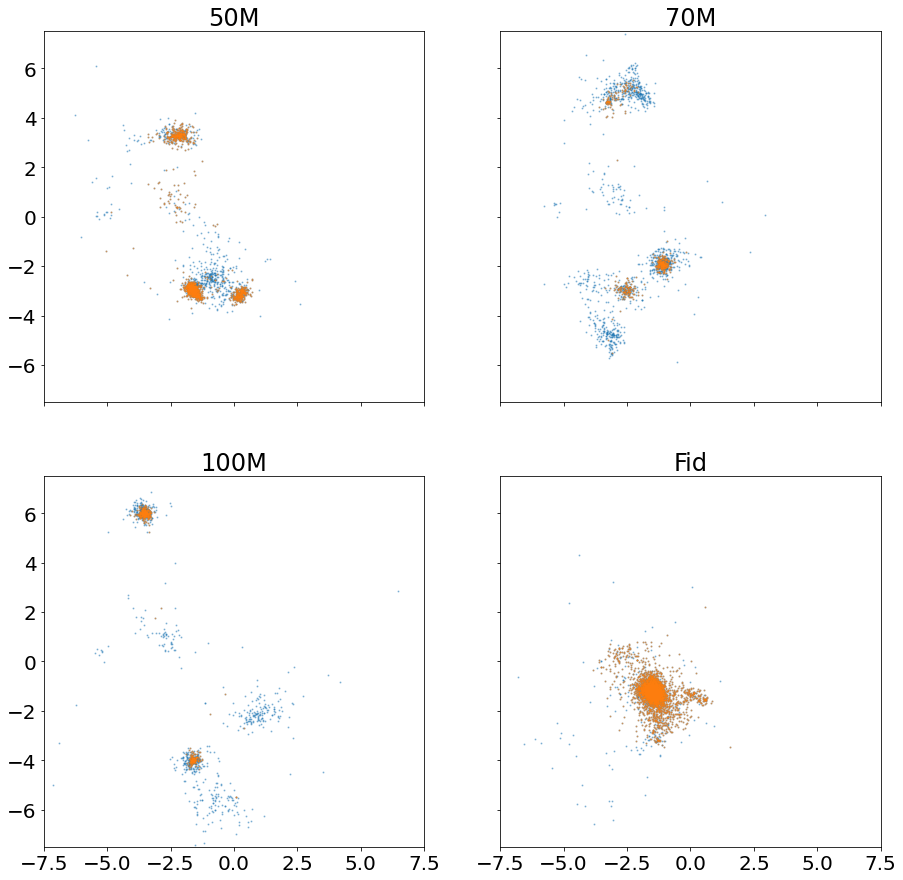

In [61]:
print(L50_all.mass[np.where(L50_all.tag==1.)].max().value_in(u.MSun))
print(L50_iter.mass[np.where(L50_iter.tag==1.)].max().value_in(u.MSun))

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

fig, axs = plt.subplots(2,2,sharex=True,sharey=True)
fig.set_size_inches(15, 15)

alpha=0.4

axs[0,0].set_title("50M")
axs[0,0].set_xlim(-7.5,7.5)
axs[0,0].set_ylim(-7.5,7.5)
axs[0,0].scatter(L50_all[np.where(L50_all.tag==1.)].x.value_in(u.pc), 
                 L50_all[np.where(L50_all.tag==1.)].y.value_in(u.pc), 
                 s=1, alpha=alpha, label='all')
axs[0,0].scatter(L50_iter[np.where(L50_iter.tag==1.)].x.value_in(u.pc), 
                 L50_iter[np.where(L50_iter.tag==1.)].y.value_in(u.pc), 
                 s=1, alpha=alpha, label='bound')

axs[0,1].set_title("70M")
axs[0,1].scatter(L70_all[np.where(L70_all.tag==1.)].x.value_in(u.pc), 
                 L70_all[np.where(L70_all.tag==1.)].y.value_in(u.pc), 
                 s=1, alpha=alpha)
axs[0,1].scatter(L70_iter[np.where(L70_iter.tag==1.)].x.value_in(u.pc), 
                 L70_iter[np.where(L70_iter.tag==1.)].y.value_in(u.pc), 
                 s=1, alpha=alpha)

axs[1,0].set_title("100M")
axs[1,0].scatter(L100_all[np.where(L100_all.tag==1.)].x.value_in(u.pc), 
                 L100_all[np.where(L100_all.tag==1.)].y.value_in(u.pc), 
                 s=1, alpha=alpha)
axs[1,0].scatter(L100_iter[np.where(L100_iter.tag==1.)].x.value_in(u.pc), 
                 L100_iter[np.where(L100_iter.tag==1.)].y.value_in(u.pc), 
                 s=1, alpha=alpha)

axs[1,1].set_title("Fid")
axs[1,1].scatter(Lv_all[np.where(Lv_all.tag==1.)].x.value_in(u.pc), 
                 Lv_all[np.where(Lv_all.tag==1.)].y.value_in(u.pc), 
                 s=1, alpha=alpha)
axs[1,1].scatter(Lv_iter[np.where(Lv_iter.tag==1.)].x.value_in(u.pc), 
                 Lv_iter[np.where(Lv_iter.tag==1.)].y.value_in(u.pc), 
                 s=1, alpha=alpha)

plt.show(fig)


| Run | Total Mass (Msun) | Iter Bound Mass (Msun)

In [109]:
print("L50 num, mass all:",len(L50_all.mass[np.where(L50_all.tag==1.)]), ',',
      L50_all.mass[np.where(L50_all.tag==1.)].sum().value_in(u.MSun))
print("L50 num, mass bound:",len(L50_iter.mass[np.where(L50_iter.tag==1.)]), ',',
      L50_iter.mass[np.where(L50_iter.tag==1.)].sum().value_in(u.MSun))
print("L70 num, mass all:",len(L70_all.mass[np.where(L70_all.tag==1.)]), ',',
      L70_all.mass[np.where(L70_all.tag==1.)].sum().value_in(u.MSun))
print("L70 num, mass bound:",len(L70_iter.mass[np.where(L70_iter.tag==1.)]), ',',
      L70_iter.mass[np.where(L70_iter.tag==1.)].sum().value_in(u.MSun))
print("L100 num, mass all:",len(L100_all.mass[np.where(L100_all.tag==1.)]), ',',
      L100_all.mass[np.where(L100_all.tag==1.)].sum().value_in(u.MSun))
print("L100 num, mass bound:",len(L100_iter.mass[np.where(L100_iter.tag==1.)]), ',',
      L100_iter.mass[np.where(L100_iter.tag==1.)].sum().value_in(u.MSun))
print("Lv num, mass all:",len(Lv_all.mass[np.where(Lv_all.tag==1.)]), ',',
      Lv_all.mass[np.where(Lv_all.tag==1.)].sum().value_in(u.MSun))
print("Lv num, mass bound:",len(Lv_iter.mass[np.where(Lv_iter.tag==1.)]), ',',
      Lv_iter.mass[np.where(Lv_iter.tag==1.)].sum().value_in(u.MSun))

L50 num, mass all: 2157 , 1503.03726136
L50 num, mass bound: 1582 , 1104.11610733
L70 num, mass all: 1586 , 998.606134728
L70 num, mass bound: 468 , 376.242221617
L100 num, mass all: 1389 , 893.529194883
L100 num, mass bound: 542 , 379.125849823
Lv num, mass all: 6305 , 3603.56283643
Lv num, mass bound: 6111 , 3477.85621301


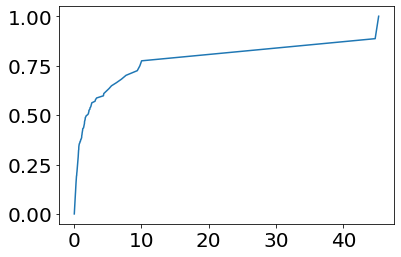

In [99]:

sorted_masses = np.sort(L50_rmvd.mass.value_in(u.MSun))
mass_cumsum = np.cumsum(sorted_masses)
numss = np.arange(0,len(sorted_masses))
plt.plot(sorted_masses,mass_cumsum/max(mass_cumsum))
